In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher

In [2]:
# adapted from Ruan on stackoverflow
class GPT2:
    def __init__(self):
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    
    def get_predictions(self, sentence):
        # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions
    
    def get_next_word_probabilities(self, sentence, n=50257):
        predictions = self.get_predictions(sentence)
        next_token_candidates_tensor = predictions[0, -1, :] # Get the next token candidates.
        topk_candidates_indexes = torch.topk(
            next_token_candidates_tensor, n).indices.tolist() # Get the top k next token candidates.
        all_candidates_probabilities = torch.nn.functional.softmax( # Get the token probabilities for all candidates.
            next_token_candidates_tensor, dim=-1)
        topk_candidates_probabilities = \
            all_candidates_probabilities[topk_candidates_indexes].tolist() # Filter the token probabilities for the top k candidates.
        topk_candidates_tokens = \
            [self.tokenizer.decode([idx]).strip() for idx in topk_candidates_indexes] # Decode the top k candidates back to words.
        return list(zip(topk_candidates_tokens, topk_candidates_probabilities))
        
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
model = GPT2()

In [3]:
probs  = model.get_next_word_probabilities("Where did you get that pencil", 10000)
target = 'form'
probsp = [(word, prob, edit_distance(target, word, transpositions=True)) for word, prob in probs] #if prob >= target_prob]
target_probs = sorted(probsp, key=lambda x: x[2])
if not target_probs[0][2]:
    target_prob = target_probs[0][1]
else:
    target_prob = 0
probsp[:10]

[('?', 0.20764535665512085, 4),
 ('from', 0.11485478281974792, 1),
 ('?"', 0.10430236160755157, 4),
 ('out', 0.037435825914144516, 3),
 ('and', 0.033517852425575256, 4),
 (',', 0.026630159467458725, 4),
 ('in', 0.022407740354537964, 4),
 ('on', 0.016653669998049736, 3),
 ('s', 0.01657014898955822, 4),
 ('ed', 0.014303337782621384, 4)]

In [4]:
target_probs[:10]

[('form', 0.0003367905446793884, 0),
 ('form', 4.9513405429024715e-06, 0),
 ('from', 0.11485478281974792, 1),
 ('for', 0.013223378919064999, 1),
 ('fork', 4.086824264959432e-05, 1),
 ('worm', 1.4074849786993582e-05, 1),
 ('foam', 7.001713584031677e-06, 1),
 ('firm', 6.5439153331681155e-06, 1),
 ('farm', 6.021182343829423e-06, 1),
 ('worm', 5.306787443259964e-06, 1)]

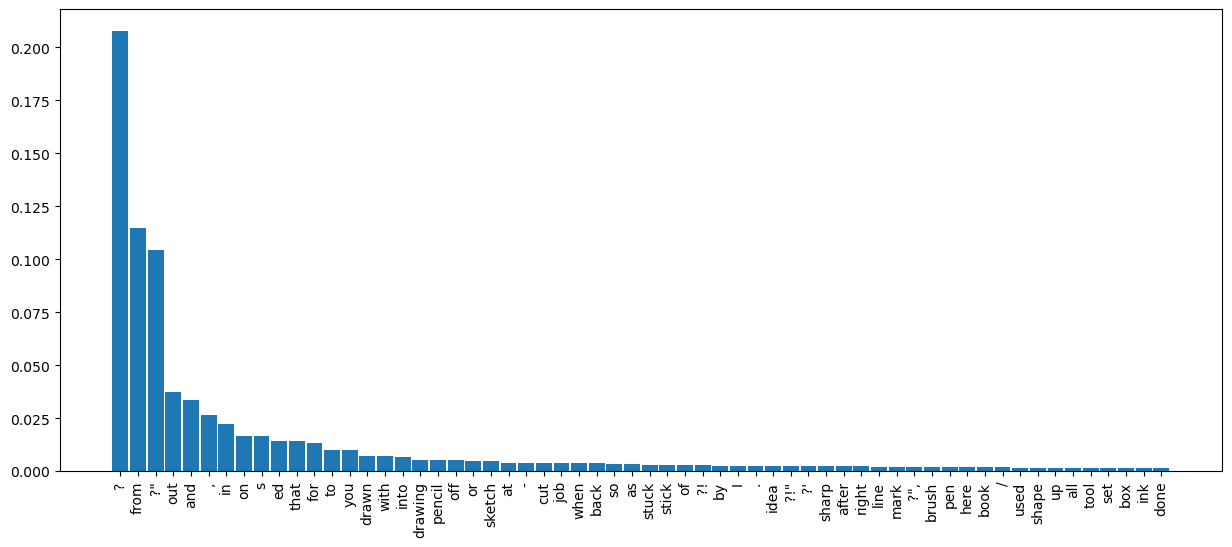

In [5]:
fig, ax = plt.subplots(figsize=(15,6))
probs = np.array(probsp[:60])
ax.bar(probs[:,0], probs[:,1].astype(float), width=0.9)
plt.xticks(rotation=90, fontsize=10)
plt.show()

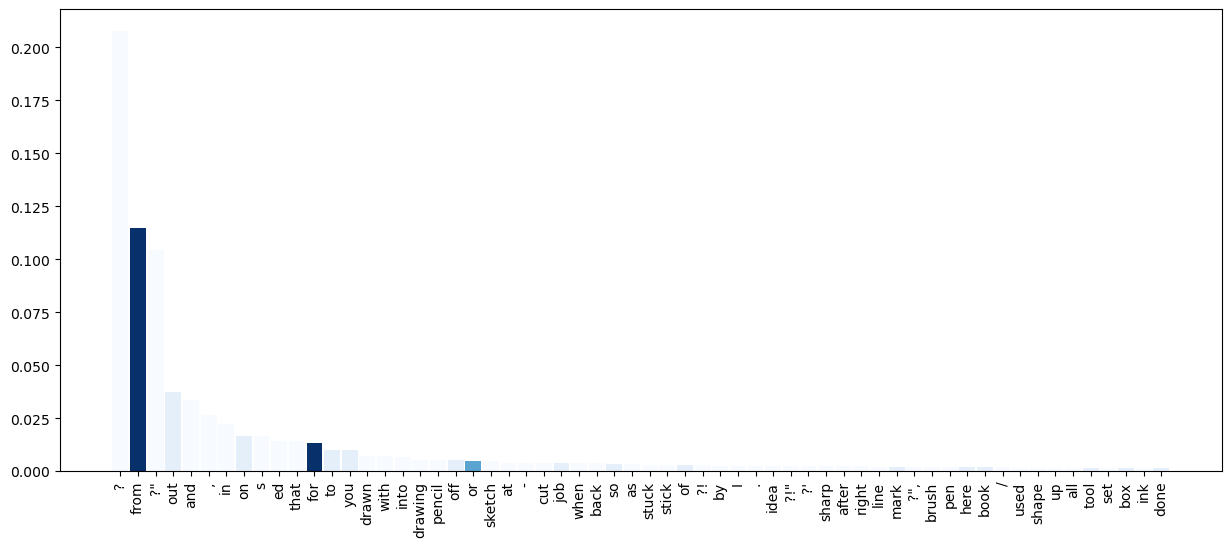

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
cmap = mpl.colormaps['Blues_r']
norm = mpl.colors.Normalize(vmin=1, vmax=3.2)
ax.bar(probs[:,0], probs[:,1].astype(float), color=cmap(norm(probs[:,2].astype(int))), width=0.9)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [7]:
#adjusted_prob = [(word, prob, prob/((dist+1)**2), dist) for word, prob, dist in probsp if dist <= 2] # probability inversely proportional to distance squared
#adjsuted_prob = sorted(adjusted_prob, key=lambda x: x[1], reverse=True)
#adjusted_prob[:5]
close_prob = [(word, prob, dist) for word, prob, dist in probsp if dist <= 2]
close_prob[:5]

[('from', 0.11485478281974792, 1),
 ('for', 0.013223378919064999, 1),
 ('or', 0.004708147142082453, 2),
 ('work', 0.000819033884909004, 2),
 ('form', 0.0003367905446793884, 0)]

In [8]:
top_dist_one = 0
top_dist_two = 0
for word, prob, dist in close_prob:
    if dist == 1 and not top_dist_one:
        top_dist_one = (word, prob)
    elif dist == 2 and not top_dist_two:
        top_dist_two = (word, prob)
    if top_dist_one and top_dist_two:
        break
if not top_dist_one:
    top_dist_one = ('not found', 0)
if not top_dist_two:
    top_dist_two = ('not found', 0)
top_dist_one, top_dist_two

(('from', 0.11485478281974792), ('or', 0.004708147142082453))

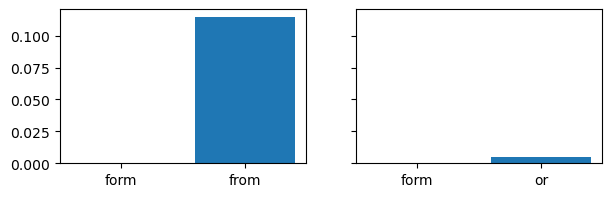

0.0003368 0.1148548 0.0047081


In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(7, 2))
ax1.bar([target, top_dist_one[0]], [target_prob, top_dist_one[1]])
ax2.bar([target, top_dist_two[0]], [target_prob, top_dist_two[1]])
plt.show()
print("{:1.7f} {:1.7f} {:1.7f}".format(target_prob, top_dist_one[1], top_dist_two[1]))

In [10]:
def getSuggestions(string, n=1):
    words  = string.split()
    prompt = ' '.join(words[:-1])
    target = words[-1]
    probs  = model.get_next_word_probabilities(prompt, 10000)
    probsp = [(word, prob, edit_distance(target, word, substitution_cost=1, transpositions=True)) for word, prob in probs]
    #adjusted_prob = [(word, prob, prob/((dist+1)**2), dist) for word, prob, dist in probsp if dist <= 2]
    close_prob = [(word, prob, dist) for word, prob, dist in probsp if dist <= 2]
    closest = sorted(probsp, key=lambda x: x[2])[0]
    if not closest[2]:
        target_prob = closest[1]
    else:
        target_prob = None
    return close_prob[:n], target_prob

In [11]:
getSuggestions("Hi Michael,\n\nMy office ours", 3) # maybe decide from original prob under a threshold, if prob

([('hours', 0.0016539501957595348, 1),
  ('or', 0.0012165819061920047, 2),
  ('runs', 0.00036050824564881623, 2)],
 None)